# Capstone Project : Battle of the Neighborhoods

## Housing Market in Paris

### Business problem

Paris is one of the most expensive cities in the world when it comes to real estate. Finding an apartment in Paris is a true mission, and can take up to months of searching, appointments, visits, only to see the apartment go to someone else for most cases. However, with interest rates as low as 1% for a credit line over 25 years, and with real estate picking up value year after year at high percentages, becoming a homeowner has become appealing to most Parisians, as soon as they become active in the work market.

With demand for real estate increasing in Paris and offers rare, expensive and far between, it is reasonable to assume that home buyers need to be guided in this important decision making. In this project, we use machine learning techniques to cluster neighborhoods based on real estate prices and make recommendations based on venues of the surrounding area in order to help them make the best suited decision for them.

### Data description

To solve the problem at hand, we will be using data scraped from the French governmental website. This database will give us access to addresses of properties, their values, their types, their surfaces and the number of rooms in them. We will also be using the foursquare API interface to explore the neighborhoods and recommend locations according to the presence of nearby accommodations, by using maps for visualization. In order to get the coordinates of our addresses, we will be creating a file from an API on a French governmental website.

Combining data on the properties, their features, their locations and their surroundings, we should be able to provide the home buyers with enough insight to make informed decisions.


### Data sources

* https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/
* https://geo.api.gouv.fr/adresse
* https://opendata.paris.fr/explore/dataset/arrondissements/export/?location=13,48.85156,2.32327

### Librairies

Let's import all the librairies needed to accomplish this project

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import os

#sklaern
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#matplot
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#Geocoder
!conda install -c conda-forge geopy --yes
! pip install geopandas
! pip install geocoder
from geopy.geocoders import Nominatim
import geocoder

#Folium
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

### Data

Let's then import our data and get the Foursqure API credentials.

In [2]:
#Real Estate features
!wget 'https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2' -O housingdata.csv
#Geo data
!wget 'https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr' -O arrondissements.geojson

--2020-03-11 14:36:03--  https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.93
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://static.data.gouv.fr/resources/demandes-de-valeurs-foncieres/20191030-122930/valeursfoncieres-2019.txt [following]
--2020-03-11 14:36:03--  https://static.data.gouv.fr/resources/demandes-de-valeurs-foncieres/20191030-122930/valeursfoncieres-2019.txt
Resolving static.data.gouv.fr (static.data.gouv.fr)... 37.59.183.93
Connecting to static.data.gouv.fr (static.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135748668 (129M) [text/plain]
Saving to: ‘housingdata.csv’

100%[======================================>] 135,748,668 64.6MB/s   in 2.0s   

2020-03-11 14:36:05 (64.6 MB/s) - ‘housingdata.csv’ saved [135748668/135748668]

--202

In [3]:
CLIENT_ID = 'XTSCV4KEEHKCFX05KAULBGJV0EIBJNRIAW2CU5KA4DLCR5J2' 
CLIENT_SECRET = 'PTCL5ICUOUNP4Z5ZOLXOVGHJPU4PU42IVBVJJI32BRNHYXOV' 
VERSION = '20180605' # Foursquare API version

print('Credentials for Foursquare generated')

Credentials for Foursquare generated


### Pre-processing Data

And let's first take a look at the data. 
It looks like our database containing the properties features needs cleaning. Let's take care of this first.

First of all, we're going to get rid of useless columns, rename the ones we're keeping, restrict the observations to the Paris area, restrict the properties types to habitable, deal with our missing data and inspect our data types and change them when necessary. We will then use the api to get the coordinnates.

In [4]:
df = pd.read_csv('housingdata.csv', sep = '|')
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (14,18,23,24,26,28,33,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Code service CH,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11/01/2019,Vente,...,NaN,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11/01/2019,Vente,...,NaN,2,2.0,Appartement,NaN,67.0,3.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,08/02/2019,Vente,...,NaN,0,1.0,Maison,NaN,118.0,4.0,AG,PARC,913.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,08/02/2019,Vente,...,NaN,0,1.0,Maison,NaN,118.0,4.0,S,NaN,1000.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/04/2019,Vente,...,NaN,0,1.0,Maison,NaN,60.0,3.0,S,NaN,96.0


In [5]:
# dropping useless columns
df.drop(['Code service CH', 'Reference document', '1 Articles CGI', '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI', 'No disposition', 'Date mutation', 'B/T/Q', 'Code voie', 
         'Prefixe de section', 'Section', 'No plan', 'No Volume', '1er lot', 'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot', '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot', 
         'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot','Nombre de lots', 'Nature culture', 'Nature culture speciale', 'Surface terrain', 'Identifiant local', 'Code type local', 'Code commune'], 
            axis = 1, inplace = True)

#Change the columns names
df.rename(columns = {'Nature mutation':'Nature_of_transaction', 'Valeur fonciere':'Price', 'No voie':'Num', 'Type de voie':'Type_of_street', 'Voie':'Street', 'Code postal':'Postal_code', 
                     'Commune':'Town', 'Code departement':'Department_code', 'Type local':'Type_of_property','Surface reelle bati':'Surface', 'Nombre pieces principales':'Number_of_rooms'}, inplace = True)

#Restrict the observations to Paris, only appartments and house
df_paris = df[df['Department_code'] == 75].reset_index(drop=True)

#let's check out what types of properties we have
df_paris['Type_of_property'].value_counts()

Appartement                                 13545
Dépendance                                   5259
Local industriel. commercial ou assimilé     2177
Maison                                         56
Name: Type_of_property, dtype: int64

We see that houses are marginal compared to the number of appartments in Paris, we will only restrict our data to appartments for simplicity, and then look at our missing data.

In [6]:
#Restricting the dataset to appartements only
df_paris = df_paris[df_paris['Type_of_property'] == 'Appartement'].reset_index(drop=True)

#Checking out our missing data
missing_data = df_paris.isnull()

#Determining what variable contain missing data
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

Nature_of_transaction
False    13545
Name: Nature_of_transaction, dtype: int64

Price
False    13496
True        49
Name: Price, dtype: int64

Num
False    13545
Name: Num, dtype: int64

Type_of_street
False    13538
True         7
Name: Type_of_street, dtype: int64

Street
False    13545
Name: Street, dtype: int64

Postal_code
False    13545
Name: Postal_code, dtype: int64

Town
False    13545
Name: Town, dtype: int64

Department_code
False    13545
Name: Department_code, dtype: int64

Type_of_property
False    13545
Name: Type_of_property, dtype: int64

Surface
False    13545
Name: Surface, dtype: int64

Number_of_rooms
False    13545
Name: Number_of_rooms, dtype: int64



We can see that we have 56 rows in total with missing values over 13545 rows. We can simply drop these rows.

In [7]:
#drop missing data
df_paris.dropna(subset=['Price', 'Type_of_street'], axis=0, inplace=True)
df_paris.reset_index(drop=True, inplace=True)

#Check out types of variables
df_paris.dtypes 

Nature_of_transaction     object
Price                     object
Num                      float64
Type_of_street            object
Street                    object
Postal_code              float64
Town                      object
Department_code           object
Type_of_property          object
Surface                  float64
Number_of_rooms          float64
dtype: object

Great ! Now that our dataframe has no missing values, we can see that the number of the street, the postal code and the number of rooms are floats. We should convert them to integers.
Next, we can combine our columns into one address column, and use our API to get coordinates for our appartment locations.

In [8]:
#Change the columns types
df_paris[["Num"]] = df_paris[["Num"]].astype("int")
df_paris[["Postal_code"]] = df_paris[["Postal_code"]].astype("int")
df_paris[["Number_of_rooms"]] = df_paris[["Number_of_rooms"]].astype("int")
df_paris['Price'] = df_paris['Price'].str.replace(',','.')
df_paris[["Price"]] = df_paris[["Price"]].astype("float")

# Create an address column in our dataframe and add coordinates
df_paris['Address'] = df_paris['Num'].astype(str) + ' ' + df_paris['Type_of_street'] + ' ' +df_paris['Street'] + ' ' +df_paris['Postal_code'].astype(str)
df_paris['Address'] = df_paris['Address'].str.replace(' D '," D'")
df_paris.drop(['Num', 'Type_of_street', 'Street' ], axis = 1, inplace = True)

#Check our dataframe
df_paris.head()

,Nature_of_transaction,Price,Postal_code,Town,Department_code,Type_of_property,Surface,Number_of_rooms,Address
0,Vente,1196000.0,75001,PARIS 01,75,Appartement,112.0,3,17 RUE DUPHOT 75001
1,Vente,1570490.0,75003,PARIS 03,75,Appartement,104.0,3,13 RUE DE THORIGNY 75003
2,Vente,5400.0,75003,PARIS 03,75,Appartement,21.0,1,79 RUE DES GRAVILLIERS 75003
3,Vente,230000.0,75003,PARIS 03,75,Appartement,26.0,1,4 RUE BLONDEL 75003
4,Vente,955750.0,75008,PARIS 08,75,Appartement,80.0,3,82 BD MALESHERBES 75008


We will now create an intermediate dataframe to call the api and get the coordinnates.

In [9]:
#Remove file if it already exists
if os.path.exists('results.csv'):
    os.remove('results.csv')
    
#Create an intermediate dataframe, save it as csv
df_paris_bis = df_paris[['Nature_of_transaction', 'Address', 'Postal_code', 'Town']]
df_paris_bis.to_csv('Paris_addresses.csv', sep=',', index= False)

#Coordinnates
!curl -X POST -F data=@Paris_addresses.csv -F columns=Address -F columns=Postal_code https://api-adresse.data.gouv.fr/search/csv/ >> results.csv

#Get result into a dataframe
df_result = pd.read_csv("results.csv")

#Cleaning the dataframe
df_result.drop(['Nature_of_transaction', 'result_label', 'result_score', 'result_type', 'result_id', 'result_housenumber', 'result_name', 'result_street', 'result_postcode', 'result_city', 'result_context', 
                'result_citycode', 'result_oldcitycode', 'result_oldcity', 'result_district' , 'Postal_code', 'Town'], axis = 1, inplace = True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3553k    0 2951k  100  602k  65668  13411  0:00:46  0:00:46 --:--:-- 682850:13  0:00:13 --:--:-- 68740


In [10]:
#Merge the two dataframes
paris_data = pd.concat([df_paris, df_result], axis=1, sort=False)
paris_data = paris_data.loc[:,~paris_data.columns.duplicated()]
paris_data.dropna(subset=['latitude', 'longitude'], axis=0, inplace=True)
paris_data.head()

,Nature_of_transaction,Price,Postal_code,Town,Department_code,Type_of_property,Surface,Number_of_rooms,Address,latitude,longitude
0,Vente,1196000.0,75001,PARIS 01,75,Appartement,112.0,3,17 RUE DUPHOT 75001,48.868446,2.325456
1,Vente,1570490.0,75003,PARIS 03,75,Appartement,104.0,3,13 RUE DE THORIGNY 75003,48.860077,2.363265
2,Vente,5400.0,75003,PARIS 03,75,Appartement,21.0,1,79 RUE DES GRAVILLIERS 75003,48.864708,2.353513
3,Vente,230000.0,75003,PARIS 03,75,Appartement,26.0,1,4 RUE BLONDEL 75003,48.868529,2.354921
4,Vente,955750.0,75008,PARIS 08,75,Appartement,80.0,3,82 BD MALESHERBES 75008,48.879896,2.314034


Before we map our data, let's look at the statistical caracteristics of our data, and limit our dataframe to affordable appartments.

In [11]:
#Statistics of the data
paris_data.describe()

,Price,Postal_code,Surface,Number_of_rooms,latitude,longitude
count,1.348800e+04,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000
mean,1.270758e+06,75013.617141,52.268906,2.356168,48.868107,2.340178
std,3.668059e+06,5.459741,40.973162,1.299085,0.020028,0.033829
min,1.000000e+00,75001.000000,3.000000,0.000000,48.819513,2.256376
25%,2.570000e+05,75009.000000,27.000000,1.000000,48.855356,2.319695
50%,4.320000e+05,75016.000000,41.000000,2.000000,48.872870,2.342834
75%,8.203300e+05,75018.000000,64.000000,3.000000,48.884102,2.361118
max,7.310000e+07,75020.000000,904.000000,12.000000,48.900391,2.412651


Looking at our statistics, let's keep the appartments with a lower price than our median (432k€) and with a decent surface, in this case higher than our 1er quartile (27m²)

In [12]:
#Create our dataframe for affordable housing
paris_aff = paris_data[(paris_data['Price'] <= 432000.0) & (paris_data['Surface'] >= 27.0)].reset_index(drop=True)
paris_aff.head()

,Nature_of_transaction,Price,Postal_code,Town,Department_code,Type_of_property,Surface,Number_of_rooms,Address,latitude,longitude
0,Vente,200000.0,75008,PARIS 08,75,Appartement,28.0,1,39 RUE D'ARTOIS 75008,48.874096,2.305705
1,Vente,300000.0,75003,PARIS 03,75,Appartement,28.0,1,170 RUE DU TEMPLE 75003,48.866457,2.361764
2,Vente,400000.0,75008,PARIS 08,75,Appartement,36.0,2,17 RUE DE NAPLES 75008,48.879660,2.319647
3,Vente,312200.0,75008,PARIS 08,75,Appartement,31.0,2,10 RUE DE LISBONNE 75008,48.877885,2.316966
4,Vente,400000.0,75001,PARIS 01,75,Appartement,40.0,2,5 RUE JEAN JACQUES ROUSSEAU 75001,48.862289,2.339991


In [13]:
#Get Paris coordinnates
address = 'Paris, France'

geolocator = Nominatim()
location = geolocator.geocode(address)
Latitude = location.latitude
Longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(Latitude, Longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [14]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[Latitude, Longitude], zoom_start=13)

# add markers to map
for lat, lng in zip(paris_aff['latitude'], paris_aff['longitude']) : 
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_paris)  
map_paris

## Methodology

### 1. Exploring the surroundings with Foursquare

Now we want to explore the surroundings of our addresses, but since the foursquare api has a daily limit to get the venues, we'll create a smaller dataframe that contains a sample of the best Paris appartments in terms of price and surface.

In [15]:
#Restrict our dataabse to a much smaller sample
paris_best = paris_aff[(paris_aff['Price'] <= 320000.0) & (paris_aff['Price'] > 150000.0) & (paris_aff['Surface'] >= 40.0) & (paris_aff['Number_of_rooms'] > 2)].reset_index(drop=True)
paris_best.head()

,Nature_of_transaction,Price,Postal_code,Town,Department_code,Type_of_property,Surface,Number_of_rooms,Address,latitude,longitude
0,Vente,273000.0,75008,PARIS 08,75,Appartement,60.0,3,22 RUE BOISSY D'ANGLAS 75008,48.869247,2.322176
1,Vente,285000.0,75008,PARIS 08,75,Appartement,40.0,3,12 RUE DE L ARCADE 75008,48.871494,2.323638
2,Vente,200000.0,75001,PARIS 01,75,Appartement,83.0,3,14 RUE DES BOURDONNAIS 75001,48.858970,2.344015
3,Vente,193700.0,75001,PARIS 01,75,Appartement,132.0,7,17 RUE SAINT ROCH 75001,48.865284,2.332115
4,Vente,220000.0,75003,PARIS 03,75,Appartement,180.0,6,4 IMP SAINT CLAUDE 75003,48.860292,2.365743


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=200, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        #print(f"result {results}")
        if results['meta']['code'] != 200:
            print(f"Something went wrong: {results}")
            continue
        if results["response"]['groups'][0]['items']:
            results = results["response"]['groups'][0]['items']
            print(f"{name} {len(results)} venues")
        else:
            continue
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# Run the above function on each district and create a new dataframe called venues and display it.
venues = getNearbyVenues(names=paris_best['Address'],latitudes=paris_best['latitude'],longitudes=paris_best['longitude'])

22 RUE BOISSY D'ANGLAS 75008 42 venues
12 RUE DE L ARCADE 75008 27 venues
14 RUE DES BOURDONNAIS 75001 21 venues
17 RUE SAINT ROCH 75001 41 venues
4 IMP SAINT CLAUDE 75003 30 venues
18 RUE CASSETTE 75006 23 venues
16 RUE BOUCHARDON 75010 32 venues
16 RUE PIERRE FONTAINE 75009 33 venues
67 RUE DE L AQUEDUC 75010 8 venues
28 RUE PIERRE FONTAINE 75009 33 venues
61 RUE DU FBG DU TEMPLE 75010 21 venues
175 QUAI DE VALMY 75010 16 venues
208 RUE SAINT MAUR 75010 17 venues
40 RUE DES MARTYRS 75009 20 venues
16 RUE LUCIEN SAMPAIX 75010 17 venues
80 RUE DE L AQUEDUC 75010 9 venues
70 BD AUGUSTE BLANQUI 75013 5 venues
8 RUE DE L INDUSTRIE 75013 6 venues
26 RUE CLISSON 75013 3 venues
19 RUE BOBILLOT 75013 31 venues
16 RUE DE LA GLACIERE 75013 11 venues
5 RUE VULPIAN 75013 1 venues
90 RUE BOBILLOT 75013 4 venues
7 RUE BOURGON 75013 6 venues
90 AV D'IVRY 75013 29 venues
27 RUE DU DESSOUS DES BERGES 75013 7 venues
84 BD MASSENA 75013 4 venues
105 RUE DIDOT 75014 9 venues
45 BD BRUNE 75014 8 venues
1 

In [18]:
print(f"Venues shape: {venues.shape}")
venues['Venue Category'].value_counts().head(15)

Venues shape: (1909, 7)


French Restaurant      243
Hotel                  112
Bar                    108
Italian Restaurant      87
Bakery                  80
Café                    56
Pizza Place             54
Japanese Restaurant     50
Supermarket             49
Restaurant              38
Thai Restaurant         36
Bistro                  36
Coffee Shop             35
Plaza                   34
Asian Restaurant        32
Name: Venue Category, dtype: int64

In [19]:
venues.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,22 RUE BOISSY D'ANGLAS 75008,48.869247,2.322176,La Maison du Whisky,48.870775,2.321532,Liquor Store
1,22 RUE BOISSY D'ANGLAS 75008,48.869247,2.322176,Cercle de l'Union Interalliée,48.868963,2.319950,Lounge
2,22 RUE BOISSY D'ANGLAS 75008,48.869247,2.322176,Honor,48.869634,2.319596,Coffee Shop
3,22 RUE BOISSY D'ANGLAS 75008,48.869247,2.322176,Christian Dior,48.869046,2.323557,Boutique
4,22 RUE BOISSY D'ANGLAS 75008,48.869247,2.322176,Gucci,48.868561,2.323005,Boutique


In [20]:
# get the List of Unique Categories
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 192 uniques categories.


In [21]:
# One hot encoding
paris_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
paris_onehot['Address'] = venues['Neighbourhood']
paris_grouped = paris_onehot.groupby('Address').mean().reset_index()
paris_grouped

,Address,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Track Stadium,Tram Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,1 AV REILLE 75014,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1 CITE HERMEL 75018,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.035714,0.035714,0.035714,0.000000,0.000000,0.0
2,100 AV DES TERNES 75017,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,105 RUE DIDOT 75014,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,0.000000,0.0
4,11 RUE CHAPPE 75018,0.000000,0.0,0.000000,0.000000,0.000000,0.027778,0.027778,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.027778,0.000000,0.000000,0.000000,0.0
5,11 RUE DE L ARSENAL 75004,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.142857,0.000000,0.000000,0.000000,0.000000,0.0
6,11 RUE EUGENE JUMIN 75019,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,11 RUE SAINT LUC 75018,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,11 SQ VITRUVE 75020,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,118 AV DE FLANDRE 75019,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [22]:
# What are the top 5 venues nearby profitable real estate investments?

num_top_venues = 5

for hood in paris_grouped['Address']:
    print("----"+str(hood)+"----")
    temp = paris_grouped[paris_grouped['Address'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1 AV REILLE 75014----
                 venue  freq
0   Italian Restaurant  0.12
1  Japanese Restaurant  0.12
2             Bus Stop  0.12
3                Plaza  0.12
4     Kebab Restaurant  0.12


----1 CITE HERMEL 75018----
                venue  freq
0   French Restaurant  0.18
1  Italian Restaurant  0.11
2         Pizza Place  0.11
3                 Bar  0.11
4                Café  0.07


----100 AV DES TERNES 75017----
                venue  freq
0  Italian Restaurant  0.19
1   French Restaurant  0.19
2               Hotel  0.15
3           Hotel Bar  0.08
4                 Pub  0.04


----105 RUE DIDOT 75014----
                        venue  freq
0          Falafel Restaurant  0.11
1                      Bakery  0.11
2             Thai Restaurant  0.11
3  Modern European Restaurant  0.11
4           French Restaurant  0.11


----11 RUE CHAPPE 75018----
                          venue  freq
0             French Restaurant  0.22
1            Italian Restaurant  0.11
2         

                venue  freq
0   French Restaurant  0.20
1  Italian Restaurant  0.09
2               Hotel  0.09
3          Restaurant  0.06
4                 Bar  0.06


----17 RUE SAINT ROCH 75001----
                 venue  freq
0  Japanese Restaurant  0.12
1                Hotel  0.12
2    French Restaurant  0.10
3           Restaurant  0.05
4   Italian Restaurant  0.05


----175 QUAI DE VALMY 75010----
                   venue  freq
0                  Hotel  0.12
1                    Bar  0.12
2  Indonesian Restaurant  0.06
3                 Bakery  0.06
4           Gourmet Shop  0.06


----18 RUE CASSETTE 75006----
           venue  freq
0         Bakery  0.13
1          Hotel  0.09
2           Café  0.09
3  Women's Store  0.04
4   Dessert Shop  0.04


----18 RUE ETIENNE DOLET 75020----
                 venue  freq
0                  Bar  0.22
1                 Café  0.11
2   African Restaurant  0.06
3            Gastropub  0.06
4  Moroccan Restaurant  0.06


----19 BD DELESSERT 7

                           venue  freq
0                            Bar  0.25
1                          Plaza  0.12
2                    Supermarket  0.12
3  Vegetarian / Vegan Restaurant  0.12
4              French Restaurant  0.12


----38 RUE DES ENVIERGES 75020----
                venue  freq
0   French Restaurant  0.43
1          Restaurant  0.29
2               Hotel  0.14
3              Bistro  0.14
4  African Restaurant  0.00


----39 RUE DE LA CHAPELLE 75018----
                 venue  freq
0    Food & Drink Shop  0.67
1                  Bar  0.33
2                 Park  0.00
3  Moroccan Restaurant  0.00
4        Movie Theater  0.00


----4 IMP SAINT CLAUDE 75003----
            venue  freq
0     Art Gallery  0.17
1  Clothing Store  0.10
2             Bar  0.10
3            Café  0.10
4      Restaurant  0.03


----4 RUE DE PANAMA 75018----
                           venue  freq
0                          Hotel  0.22
1                            Bar  0.22
2              French

                venue  freq
0                 Bar  0.14
1     Thai Restaurant  0.07
2  Turkish Restaurant  0.07
3       Historic Site  0.07
4           Speakeasy  0.07


----8 RUE DE L INDUSTRIE 75013----
                venue  freq
0             Theater  0.17
1   French Restaurant  0.17
2   Food & Drink Shop  0.17
3  Chinese Restaurant  0.17
4              Bakery  0.17


----8 RUE DE LA POMPE 75016----
                 venue  freq
0          Pizza Place  0.17
1    French Restaurant  0.17
2  Japanese Restaurant  0.08
3               Bakery  0.08
4   Italian Restaurant  0.08


----8 RUE RIQUET 75019----
                venue  freq
0                 Bar  0.23
1           Brasserie  0.08
2   Electronics Store  0.08
3   French Restaurant  0.08
4  Seafood Restaurant  0.08


----80 RUE DE L AQUEDUC 75010----
                 venue  freq
0               Lounge  0.11
1                  Bar  0.11
2        Historic Site  0.11
3   Dim Sum Restaurant  0.11
4  Fried Chicken Joint  0.11


----84 BD 

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Address'] = paris_grouped['Address']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1 AV REILLE 75014,Plaza,Pharmacy,Peruvian Restaurant,Italian Restaurant,Japanese Restaurant,Bus Stop,Café,Kebab Restaurant,Women's Store,Eastern European Restaurant
1,1 CITE HERMEL 75018,French Restaurant,Italian Restaurant,Bar,Pizza Place,Gastropub,Café,Record Shop,Jazz Club,Thai Restaurant,Japanese Restaurant
2,100 AV DES TERNES 75017,French Restaurant,Italian Restaurant,Hotel,Hotel Bar,Indian Restaurant,Jazz Club,Gym / Fitness Center,Bakery,Salad Place,Pub
3,105 RUE DIDOT 75014,Bakery,Thai Restaurant,Modern European Restaurant,Bike Rental / Bike Share,Falafel Restaurant,French Restaurant,Pizza Place,Hotel,Vietnamese Restaurant,Dance Studio
4,11 RUE CHAPPE 75018,French Restaurant,Italian Restaurant,Bar,Bakery,Candy Store,Burger Joint,Restaurant,Chocolate Shop,Garden,Pub
5,11 RUE DE L ARSENAL 75004,French Restaurant,Southwestern French Restaurant,Vegetarian / Vegan Restaurant,Boat or Ferry,Park,Cocktail Bar,Bar,Eastern European Restaurant,Flower Shop,Fish & Chips Shop
6,11 RUE EUGENE JUMIN 75019,Bar,Music Store,Pub,Supermarket,Steakhouse,Sandwich Place,Theater,Grocery Store,Japanese Restaurant,Plaza
7,11 RUE SAINT LUC 75018,Playground,Café,Hotel,Bookstore,Bistro,Bakery,Bar,French Restaurant,Beer Bar,English Restaurant
8,11 SQ VITRUVE 75020,Tram Station,Women's Store,Doner Restaurant,Food & Drink Shop,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,English Restaurant
9,118 AV DE FLANDRE 75019,Pharmacy,Asian Restaurant,Middle Eastern Restaurant,Bus Stop,Supermarket,Bistro,Clothing Store,Bakery,Buffet,Hotel


### 2.Clustering

Now that we have the most common venues in each of our neighborhoods, let's cluster them

In [25]:
# set number of clusters
kclusters = 5

paris_grouped_clustering = paris_grouped.drop('Address', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 0, 1, 2, 0, 2, 2], dtype=int32)

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = paris_best

# merge paris_grouped with paris_best to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Address'), on='Address')

paris_merged

,Nature_of_transaction,Price,Postal_code,Town,Department_code,Type_of_property,Surface,Number_of_rooms,Address,latitude,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Vente,273000.0,75008,PARIS 08,75,Appartement,60.0,3,22 RUE BOISSY D'ANGLAS 75008,48.869247,...,Boutique,Women's Store,French Restaurant,Men's Store,Hotel,Clothing Store,Dessert Shop,Coffee Shop,Salad Place,Lounge
1,Vente,285000.0,75008,PARIS 08,75,Appartement,40.0,3,12 RUE DE L ARCADE 75008,48.871494,...,Hotel,French Restaurant,Gourmet Shop,Salad Place,Creperie,Liquor Store,Russian Restaurant,Furniture / Home Store,Brasserie,Asian Restaurant
2,Vente,200000.0,75001,PARIS 01,75,Appartement,83.0,3,14 RUE DES BOURDONNAIS 75001,48.858970,...,French Restaurant,Cosmetics Shop,Hotel,Clothing Store,Restaurant,Japanese Restaurant,Theater,Café,Furniture / Home Store,Bar
3,Vente,193700.0,75001,PARIS 01,75,Appartement,132.0,7,17 RUE SAINT ROCH 75001,48.865284,...,Hotel,Japanese Restaurant,French Restaurant,Café,Bakery,Restaurant,Coffee Shop,Italian Restaurant,Dessert Shop,Cosmetics Shop
4,Vente,220000.0,75003,PARIS 03,75,Appartement,180.0,6,4 IMP SAINT CLAUDE 75003,48.860292,...,Art Gallery,Café,Bar,Clothing Store,Perfume Shop,Bistro,Coffee Shop,Kids Store,French Restaurant,Thai Restaurant
5,Vente,165000.0,75006,PARIS 06,75,Appartement,77.0,4,18 RUE CASSETTE 75006,48.849426,...,Bakery,Hotel,Café,Women's Store,Supermarket,French Restaurant,Mobile Phone Shop,Dessert Shop,Pizza Place,Convenience Store
6,Vente,240000.0,75010,PARIS 10,75,Appartement,71.0,3,16 RUE BOUCHARDON 75010,48.870332,...,Bar,Coffee Shop,French Restaurant,Cocktail Bar,Moroccan Restaurant,Theater,Burger Joint,Hotel,Mexican Restaurant,Lounge
7,Vente,200000.0,75009,PARIS 09,75,Appartement,100.0,5,16 RUE PIERRE FONTAINE 75009,48.881328,...,Bar,Cocktail Bar,Hotel,Italian Restaurant,French Restaurant,Candy Store,Karaoke Bar,Speakeasy,Lounge,Cheese Shop
8,Vente,268000.0,75010,PARIS 10,75,Appartement,68.0,3,67 RUE DE L AQUEDUC 75010,48.883888,...,Bar,Dim Sum Restaurant,Fried Chicken Joint,Bakery,Lounge,Athletics & Sports,Historic Site,Vegetarian / Vegan Restaurant,Fish & Chips Shop,Electronics Store
9,Vente,278485.0,75009,PARIS 09,75,Appartement,190.0,5,28 RUE PIERRE FONTAINE 75009,48.882316,...,Hotel,Italian Restaurant,French Restaurant,Bar,Comfort Food Restaurant,Café,Candy Store,Cocktail Bar,Comedy Club,Pub


In [27]:
#drop missing data
paris_merged.dropna( inplace=True)
paris_merged.reset_index(drop=True, inplace=True)

In [28]:
#Determine our variables
X = paris_merged[['Price', 'Surface']] .values 
y = paris_merged['Cluster Labels'].values

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (114, 2) (114,)
Test set: (29, 2) (29,)


In [29]:
#Find out the best k
from sklearn import metrics
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.6551724137931034 with k= 2


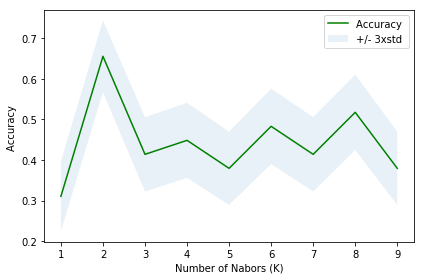

In [30]:
# Plot values of k
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

Now that we have the k that gives us the best accuracy, let's redo the clustering with the value of k that gives us the best accuracy.

In [31]:
# set number of clusters
kclusters =  mean_acc.argmax()+1

paris_grouped_clustering_bis = paris_grouped.drop('Address', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = mean_acc.argmax()+1, random_state=0).fit(paris_grouped_clustering_bis)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [32]:
# replace clustering labels
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

paris_merged = paris_best

# merge paris_grouped with paris_best to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Address'), on='Address')

paris_merged

,Nature_of_transaction,Price,Postal_code,Town,Department_code,Type_of_property,Surface,Number_of_rooms,Address,latitude,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Vente,273000.0,75008,PARIS 08,75,Appartement,60.0,3,22 RUE BOISSY D'ANGLAS 75008,48.869247,...,Boutique,Women's Store,French Restaurant,Men's Store,Hotel,Clothing Store,Dessert Shop,Coffee Shop,Salad Place,Lounge
1,Vente,285000.0,75008,PARIS 08,75,Appartement,40.0,3,12 RUE DE L ARCADE 75008,48.871494,...,Hotel,French Restaurant,Gourmet Shop,Salad Place,Creperie,Liquor Store,Russian Restaurant,Furniture / Home Store,Brasserie,Asian Restaurant
2,Vente,200000.0,75001,PARIS 01,75,Appartement,83.0,3,14 RUE DES BOURDONNAIS 75001,48.858970,...,French Restaurant,Cosmetics Shop,Hotel,Clothing Store,Restaurant,Japanese Restaurant,Theater,Café,Furniture / Home Store,Bar
3,Vente,193700.0,75001,PARIS 01,75,Appartement,132.0,7,17 RUE SAINT ROCH 75001,48.865284,...,Hotel,Japanese Restaurant,French Restaurant,Café,Bakery,Restaurant,Coffee Shop,Italian Restaurant,Dessert Shop,Cosmetics Shop
4,Vente,220000.0,75003,PARIS 03,75,Appartement,180.0,6,4 IMP SAINT CLAUDE 75003,48.860292,...,Art Gallery,Café,Bar,Clothing Store,Perfume Shop,Bistro,Coffee Shop,Kids Store,French Restaurant,Thai Restaurant
5,Vente,165000.0,75006,PARIS 06,75,Appartement,77.0,4,18 RUE CASSETTE 75006,48.849426,...,Bakery,Hotel,Café,Women's Store,Supermarket,French Restaurant,Mobile Phone Shop,Dessert Shop,Pizza Place,Convenience Store
6,Vente,240000.0,75010,PARIS 10,75,Appartement,71.0,3,16 RUE BOUCHARDON 75010,48.870332,...,Bar,Coffee Shop,French Restaurant,Cocktail Bar,Moroccan Restaurant,Theater,Burger Joint,Hotel,Mexican Restaurant,Lounge
7,Vente,200000.0,75009,PARIS 09,75,Appartement,100.0,5,16 RUE PIERRE FONTAINE 75009,48.881328,...,Bar,Cocktail Bar,Hotel,Italian Restaurant,French Restaurant,Candy Store,Karaoke Bar,Speakeasy,Lounge,Cheese Shop
8,Vente,268000.0,75010,PARIS 10,75,Appartement,68.0,3,67 RUE DE L AQUEDUC 75010,48.883888,...,Bar,Dim Sum Restaurant,Fried Chicken Joint,Bakery,Lounge,Athletics & Sports,Historic Site,Vegetarian / Vegan Restaurant,Fish & Chips Shop,Electronics Store
9,Vente,278485.0,75009,PARIS 09,75,Appartement,190.0,5,28 RUE PIERRE FONTAINE 75009,48.882316,...,Hotel,Italian Restaurant,French Restaurant,Bar,Comfort Food Restaurant,Café,Candy Store,Cocktail Bar,Comedy Club,Pub


In [50]:
# Looking at the cluster 0
paris_merged_0 = paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + [2] + [6] + list(range(11, 17))]]
paris_merged_0['Price/m²'] = paris_merged_0['Price'] / paris_merged_0['Surface']
paris_merged_0.sort_values(['Price/m²'])

,Price,Postal_code,Surface,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price/m²
38,160000.0,75016,260.0,0,Hotel,French Restaurant,Plaza,Creperie,Bakery,615.384615
51,183000.0,75016,180.0,0,Italian Restaurant,Japanese Restaurant,Asian Restaurant,Café,Women's Store,1016.666667
4,220000.0,75003,180.0,0,Art Gallery,Café,Bar,Clothing Store,Perfume Shop,1222.222222
67,223000.0,75017,168.0,0,Bakery,French Restaurant,Burger Joint,Italian Restaurant,Hotel,1327.380952
9,278485.0,75009,190.0,0,Hotel,Italian Restaurant,French Restaurant,Bar,Comfort Food Restaurant,1465.710526
3,193700.0,75001,132.0,0,Hotel,Japanese Restaurant,French Restaurant,Café,Bakery,1467.424242
48,170000.0,75016,114.0,0,Bakery,Grocery Store,Pizza Place,French Restaurant,Italian Restaurant,1491.228070
42,180000.0,75016,120.0,0,Seafood Restaurant,African Restaurant,Bakery,Dessert Shop,Restaurant,1500.000000
39,180000.0,75016,117.0,0,Italian Restaurant,Japanese Restaurant,French Restaurant,Seafood Restaurant,African Restaurant,1538.461538
49,182500.0,75016,110.0,0,Hotel,French Restaurant,Pharmacy,Burger Joint,Italian Restaurant,1659.090909


In [51]:
# Looking at the cluster 1
paris_merged_1 = paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + [2] + [6] + list(range(11, 17))]]
paris_merged_1['Price/m²'] = paris_merged_1['Price'] / paris_merged_1['Surface']
paris_merged_1.sort_values(['Price/m²'])

,Price,Postal_code,Surface,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price/m²
59,185000.00,75017,240.0,1,French Restaurant,Pizza Place,Portuguese Restaurant,Doner Restaurant,Food & Drink Shop,770.833333
53,153000.00,75017,163.0,1,French Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Bakery,938.650307
17,151000.00,75013,85.0,1,Bakery,Chinese Restaurant,Food & Drink Shop,Park,Theater,1776.470588
114,278000.00,75020,150.0,1,French Restaurant,Food & Drink Shop,Health Food Store,BBQ Joint,Bakery,1853.333333
33,180000.00,75016,94.0,1,French Restaurant,Pharmacy,Chinese Restaurant,Dance Studio,Eastern European Restaurant,1914.893617
132,160062.00,75019,71.0,1,French Restaurant,Café,Pool,Hotel Bar,Food & Drink Shop,2254.394366
36,161500.00,75016,70.0,1,French Restaurant,Wine Bar,Hotel,Pizza Place,Italian Restaurant,2307.142857
37,161500.00,75016,70.0,1,French Restaurant,Wine Bar,Hotel,Pizza Place,Italian Restaurant,2307.142857
41,164100.00,75016,64.0,1,French Restaurant,Pharmacy,Chinese Restaurant,Dance Studio,Eastern European Restaurant,2564.062500
56,313333.34,75017,103.0,1,French Restaurant,Hotel,Italian Restaurant,Restaurant,Bar,3042.071262


To get a clearer vision from our clusters, let's create a dataframe with the most frequent of the 5 most common venues in each cluster.

In [35]:
L0 = [paris_merged_0['1st Most Common Venue'].value_counts().idxmax(), paris_merged_0['2nd Most Common Venue'].value_counts().idxmax(), paris_merged_0['3rd Most Common Venue'].value_counts().idxmax(),
      paris_merged_0['4th Most Common Venue'].value_counts().idxmax(), paris_merged_0['5th Most Common Venue'].value_counts().idxmax()]

L1 = [paris_merged_1['1st Most Common Venue'].value_counts().idxmax(), paris_merged_1['2nd Most Common Venue'].value_counts().idxmax(), paris_merged_1['3rd Most Common Venue'].value_counts().idxmax(),
      paris_merged_1['4th Most Common Venue'].value_counts().idxmax(), paris_merged_1['5th Most Common Venue'].value_counts().idxmax()]

Columns = ('1st Most Common Venue','2nd Most Common Venue' ,'3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue')

Cluster_venues = pd.DataFrame([L0, L1], columns = Columns)
Cluster_venues

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,French Restaurant,Hotel,French Restaurant,French Restaurant,Food & Drink Shop
1,French Restaurant,Bar,Pizza Place,Pizza Place,Food & Drink Shop


In [36]:
#Get Paris coordinnates
address = 'Paris, France'

geolocator = Nominatim()
location = geolocator.geocode(address)
Latitude = location.latitude
Longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(Latitude, Longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


In [37]:
#drop missing data
paris_merged.dropna( inplace=True)
paris_merged.reset_index(drop=True, inplace=True)

#Make sure the clusters are integers
paris_merged['Cluster Labels'] = paris_merged['Cluster Labels'].astype(int)

# create map
map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['latitude'],paris_merged['longitude'], paris_merged['Address'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.85).add_to(map_clusters)
       
map_clusters

In [38]:
#Create a dataframe with the json file info, add the average price for each district
geo = json.load(open("arrondissements.geojson"))
geo.keys()

dict_keys(['type', 'features'])

In [39]:
geo["features"][0]['properties']

{'n_sq_co': 750001537,
 'n_sq_ar': 750000005,
 'objectid': 5,
 'l_ar': '5ème Ardt',
 'longueur': 6238.8234077,
 'surface': 2539374.62284532,
 'geom_x_y': [48.8444431505, 2.35071460958],
 'perimetre': 6239.19539614,
 'l_aroff': 'Panthéon',
 'c_arinsee': 75105,
 'c_ar': 5}

In [40]:
paris_arr = paris_merged.groupby(['Postal_code']).mean()
paris_arr.reset_index(drop=False, inplace=True)
paris_arr['Arr'] = paris_arr['Postal_code'] - 75000

In [41]:
#Create a choropleth map of the prices of the flats
Price_map = folium.Map(location=[Latitude, Longitude], zoom_start=12)

Price_map.choropleth(
    geo_data=geo,
    data=paris_arr,
    columns=['Arr', 'Price'],
    key_on="feature.properties.c_ar",
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Prices in Paris'
 )

Price_map

### 3. Results and discussion

First, it is safe to say that owning real estate in Paris is always a good idea, whether the reason behind the purchase is owning the house you live in or for a purely investment purpose. Properties are a rather safe bet in a city where demand has exceeded the offers for the past few years at least.

In this project, we were able to cluster the addresses of our data set using the k-nearest neighbor method and displaying the 5 most common venues surrounding them using the Foursquare API.
The k-nearest neighbor method showed us that the k with the best accuracy is 2, so it split our dataset into 2 clusters.

After mapping them, we notice that the cluster 1 is mostly situated in the northern part of Paris, and more precisely in the 18th, the 19th and 20th districts, but also very present in the 13th and the 16th districts. When we look at our most common venues in this cluster, we can clearly see that restaurants are the most dominant venue present in them, which makes the cluster 1 a good fit for people looking for animated streets and an active social life. We also used a heat map from the folium library to visualize where in Paris are the most expensive and the cheapest apartments. And from this map, we can see that the districts in cluster 1 are some of the most expensive in the city, the 16th being the cheapest one.

Let's now compare cluster 1 to cluster 0. This cluster seems to be more spread than cluster 1, with many restaurants nearby as well. But overall, the 2 clusters seem very similar, which leads us to assume that Paris is a homogenous city, in which the location of the investment isn't too decisive of the return on investment. This also shows in the price by square meter of the apartments, where they range from 1000€/m² to around 7500€/m² in both clusters, which lead us to draw another map, based solely on the prices.

Based on that, we can say that the most expensive real estate in Paris is in the 2nd, the 8th and the 18th districts, followed by the 19th, the 20th, the 10th, the 4th and the 13th. The investors with low budgets might want to look into buying their properties on the remaining districts, but one thing is certain: no matter where the choice lies, Paris is and will remain a good choice for real estate investment under similar economic circumstances.

